In [60]:
import sys
sys.path.append('../code')

from SamplingWalk import *
from maxcut import *
import dynamiqs as dq
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

# Problem: MaxCut

The MaximumCut (MaxCut) problem consists of partitioning the vertices of a graph into two disjoint sets so that the number (or weight) of edges between the sets is maximized. This implies defining a graph among the $n$ variables and minimizing the cost function,

$$C(x)=-\sum_{i<j}w_{ij}(x_i+x_j-2x_ix_j),$$

where $w_{ij}$ is the weight of edge $(i,j)$ connecting the variables $i$ and $j$. A decision is represented by a bitstring $x=x_1x_2\dots x_n$ of $n$ binary variables with $x_i\in \{0,1\}$. Vertex $i$ is in the first subset if $x_i=0$, and in the second one if $x_i=1$.

## Problem generation

We generate an instance of MaxCut (weighted or unweighted).

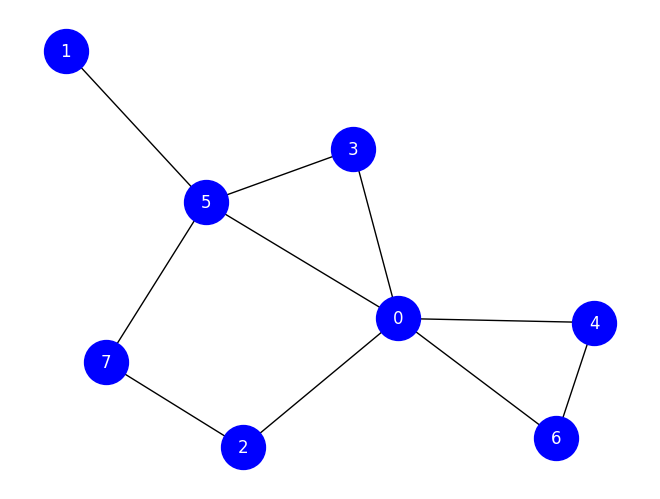

In [61]:
# Size of the graph (number of qubits)
n = 8

# Unweighted or weighted MaxCut
weighted = False

# Creation of the graph
g = nx.erdos_renyi_graph(n, 0.5)
if weighted:
    for u, v in g.edges():
        g[u][v]['weight'] = np.random.randint(-10,10) #np.random.uniform(low=np.nextafter(0, 1), high=1.0)  # weights between 0 and 1 excluded
    
    # Convert to weighted adjacency matrix
    adj_matrix = nx.to_numpy_array(g, weight='weight')
else:
    adj_matrix = nx.adjacency_matrix(g).todense()

# Display
pos = nx.spring_layout(g, seed=42)
node_size = 1000
nx.draw(
    g, pos,
    with_labels=True,
    node_color='blue',
    edge_color='black',
    node_size=node_size,
    font_color='white'
)

# Show edge weights only if weighted
if weighted:
    edge_labels = nx.get_edge_attributes(g, 'weight')
    # Round to 2 decimals for display purposes
    edge_labels = {e: f"{w:.2f}" for e, w in edge_labels.items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='magenta')

plt.show()

We first use a brute-force approach to compute the solutions of the problem to compare with the results obtained with SamBa GQW.

In [62]:
# Compute cost for all bitstrings
cost_values = []
for i in range(2**n):
    bitstr = int_to_bitstring(i,n)         # convert integer to binary vector
    cost_val = maxcut_cost(bitstr, adj_matrix)
    cost_values.append(cost_val)

# Normalize to [0,1] (1 = minimum cost, 0 = maximum cost)
cost_values = np.array(cost_values)
min_val = cost_values.min()
max_val = cost_values.max()
normalized_values = 1 - (cost_values - min_val) / (max_val - min_val)

# Create the dictionary: each key is a computational basis state (integer version) and the value is its quality (1 for optimal solutions, 0 for worst)
cost_quality_dict = {i: normalized_values[i] for i in range(2**n)}

We visualize the cost function on the solution space ($n$-dimensional hypercube) where the color of the vertices depends on their quality, which is 1 for optimal solutions and 0 for worst.

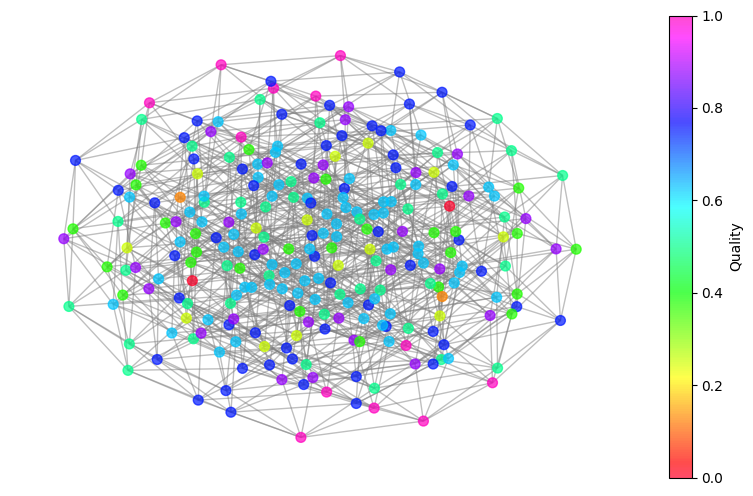

In [63]:
# Solution graph (each node of this hypercube corresponds to a computational basis state, i.e. a decision)
mixer_graph = nx.hypercube_graph(n) # hypercube since we use X-mixer for this problem

# Map vertex -> value
node_colors = [cost_quality_dict[int("".join(map(str, node)), 2)] for node in mixer_graph.nodes()]

cmap = plt.cm.gist_rainbow

# Create figure + axes explicitly
fig, ax = plt.subplots(figsize=(10, 6))

# Layout (spring or shell works well)
pos = nx.spring_layout(mixer_graph, seed=42)

# Draw graph
nodes = nx.draw_networkx_nodes(
    mixer_graph, pos, node_color=node_colors, cmap=cmap,
    vmin=0, vmax=1, node_size=50, ax=ax, alpha=0.7
)

nx.draw_networkx_edges(
    mixer_graph, pos,
    edge_color="gray",   # set all edges to gray
    alpha=0.5,
    ax=ax
)

# Add colorbar linked to nodes
cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Quality")

ax.axis("off")
plt.show()

## SamBa GQW: classical part

We create an instance of SamBa-GQW for MaxCut with $X$-mixer, then we perform the sampling protocol and compute the mean of the sampled energy gaps.

In [64]:
# Creation of instance of SamBa GQW

use_qutip = False # QuTip or Dynamiqs

if use_qutip:
    mixer = nx.adjacency_matrix(nx.hypercube_graph(n)).todense() # dense representation
else:
    mixer = dq.sparsedia_from_dict(hypercube_adjacency_sparse_final(n)) # sparse representation

samba_gqw = SamplingWalk(n,
                      cost=maxcut_cost, # MaxCut cost function
                      mixer=mixer, # Mixer (here n-dimensional hypercube)
                      use_qutip=True, # We use Dynamiqs
                      use_density_matrix=False, # State vector representation
                      convert_input_cost_fun=int_to_bitstring, # Function to convert integer to binary vectors
                      cost_kwargs={'adj_matrix':adj_matrix} # Additional inputs of the cost function
            )

# Sampling protocol
q = n**2 # Quadratic sampling
neighbors_fun = hamming_neighbors # X-mixer (hypercube) neighboring function
samba_gqw.sampling_protocol(q=q, neighbors_fun=neighbors_fun)
samba_gqw.compute_mean_gaps()

We visualize the vertices (states) sampled on the solution graph.

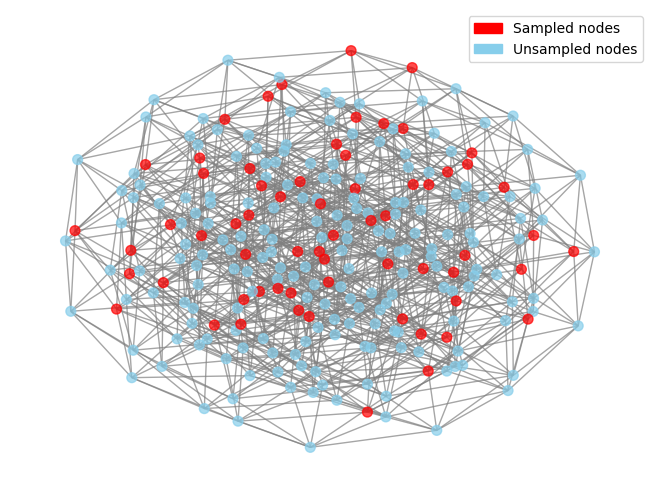

In [65]:
import matplotlib.patches as mpatches

# Map tuple nodes → integers
node_int_map = {node: int("".join(map(str, node)), 2) for node in mixer_graph.nodes()}

# Choose special nodes to highlight (integers from your sampler)
sampled_nodes = samba_gqw.sampled_states  # already integers

# Assign colors: red for special, skyblue otherwise
node_colors = [
    "red" if node_int_map[node] in sampled_nodes else "skyblue"
    for node in mixer_graph.nodes()
]

# Draw without labels
nx.draw(
    mixer_graph, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=50,
    edge_color="gray", alpha=0.7
)
# Création de la légende
red_patch = mpatches.Patch(color='red', label='Sampled nodes')
blue_patch = mpatches.Patch(color='skyblue', label='Unsampled nodes')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

### Interpolation of $\Gamma$

We construct the time-dependent hopping rate.

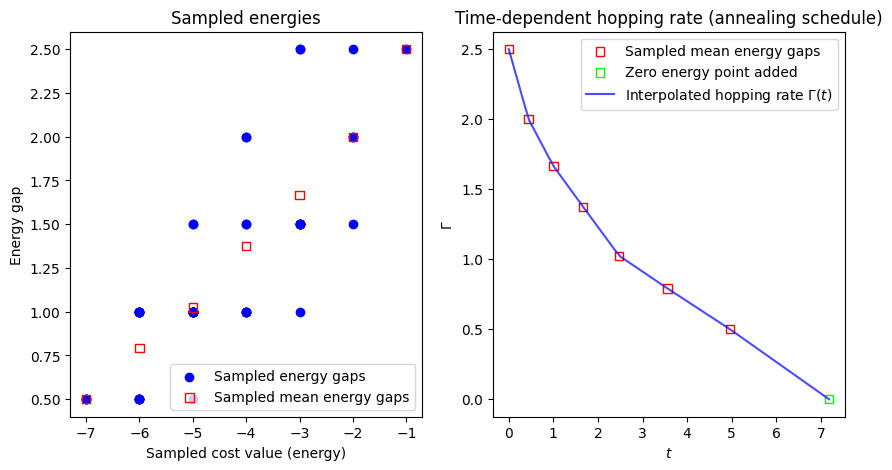

In [66]:
# Interpolation
samba_gqw.interpolate(dt=n**2)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- First plot ---
x_values = [val[0] for val in samba_gqw.sample.values()]
y_values = [val[1]/samba_gqw.local_mixer_gap for val in samba_gqw.sample.values()]

x_temp = samba_gqw.energies.copy()
new_temp = samba_gqw.np.concatenate([samba_gqw.np.array([samba_gqw.energies[0]]), x_temp])

# Scatter des cercles bleus (points "Sampled energy gaps")
axes[0].scatter(x_values, y_values, color='blue', label='Sampled energy gaps')

# Scatter des carrés rouges (hollow)
axes[0].scatter(samba_gqw.energies, samba_gqw.mean_gaps[::-1][1:], marker='s', facecolors='none', edgecolors='red', label="Sampled mean energy gaps")

axes[0].set_xlabel('Sampled cost value (energy)')
axes[0].set_ylabel('Energy gap')
axes[0].set_title('Sampled energies')
axes[0].legend()

# --- Second plot ---
# Scatter all points except last with hollow red squares
axes[1].scatter(samba_gqw.gap_dt[:-1], samba_gqw.mean_gaps[:-1], marker='s', facecolors='none', edgecolors='red', label='Sampled mean energy gaps')

# Scatter the last point in green (hollow)
axes[1].scatter(samba_gqw.gap_dt[-1:], samba_gqw.mean_gaps[-1:], marker='s', facecolors='none', edgecolors='lime', label='Zero energy point added')

# Plot interpolated hopping
axes[1].plot(samba_gqw.t_list, samba_gqw.hopping, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label="Interpolated hopping rate $\Gamma(t)$")

axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\Gamma$')
axes[1].set_title('Time-dependent hopping rate (annealing schedule)')
axes[1].legend()

plt.show()


## SamBa GQW: quantum part
We now solve the problem using SamBa GQW with (1) the Hamiltonian evolution (continuous version) and (2) the quantum circuit implementation (discrete version).

### 1- Hamiltonian evolution

In [67]:
# We perform the Hamiltonian evolution
results = samba_gqw.evolve()

# We extract the results
if samba_gqw.use_qutip:
    results_array = np.array([state.full() for state in results.states]) # array of quantum states
    times = results.times # values of evaluated time
else:
    results_array = np.array([state.to_numpy() for state in results.states]) # array of quantum states
    times = results.tsave # values of evaluated time

#### Results visualization

We compute several metrics for analysis purposes.

In [68]:
from performance_metrics import *

rank_dict = rank_solutions_by_quality(cost_quality_dict)
prob_over_time = [(np.abs(state)**2).reshape(-1) for state in results_array]
distribution_quality_over_time = [distribution_quality(pr,list(cost_quality_dict.values())) for pr in prob_over_time]
probabilities_per_rank_over_time = [[np.sum(pr[rank_dict[r]]) for pr in prob_over_time] for r in list(rank_dict.keys())]
patricipation_ratio_over_time = 1 / (2**n * np.sum(np.vstack(prob_over_time)**2, axis=1))

We first plot the several metrics over time.

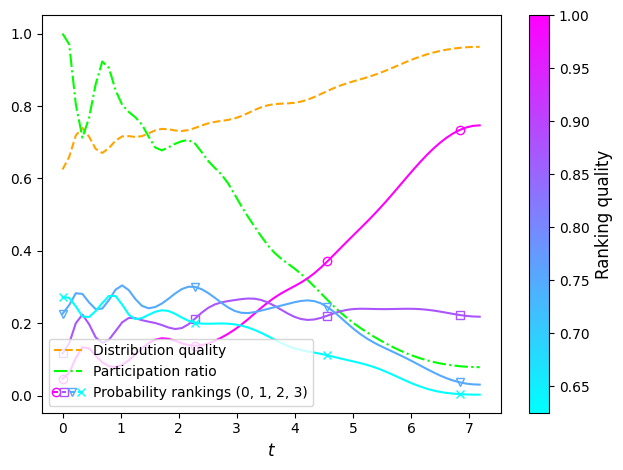

In [69]:
# We select the rankings for which we want to display the measurement probabilities over time
rank_to_display = [0,1,2,3]

# We plot several metrics over time
plot_performance(
    distribution_quality_over_time,
    patricipation_ratio_over_time,
    probabilities_per_rank_over_time,
    times,
    [cost_quality_dict[rank_dict[i][0]] for i in list(rank_dict.keys())],
    rank_list=rank_to_display,
    rank_dict=rank_dict,
    pourcentage=0,
    marker_list=None,
    markevery=20,
    markersize=6,
    show_colorbar=True,
    show_legend=True
)

We then plot the initial and final ranking distributions.

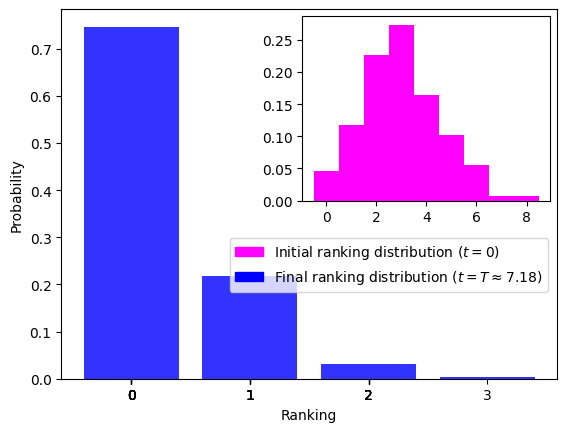

In [70]:
prob_per_rank_init = np.array([probabilities_per_rank_over_time[r][0] for r in list(rank_dict.keys())])
prob_per_rank_final = np.array([probabilities_per_rank_over_time[r][-1] for r in list(rank_dict.keys())])

plot_ranking_distribution(prob_per_rank_final=prob_per_rank_final,
                        prob_per_rank_init=prob_per_rank_init,
                        threshold=1e-3,
                        num_ticks=20,
                        inset_plot_size=50,
                        inset_plot_label='Initial ranking distribution ($t=0$)',
                        main_plot_label=rf'Final ranking distribution ($t=T\approx {round(times[-1],2)}$)',
                        save=False,
                        figname='ranking_distribution.png')

We now display the original graph with the best assignment provided by SamBa-GQW (with Hamiltonian evolution). In this part the best assignment is the computational basis state with the highest measurement probability. However, note that for the quantum circuit implementation, it will be the state with the lowest cost among the **measured** states.

Best solutions are of ranking r=0 among 9 rankings
Integer representation: [38, 44, 46, 54, 60, 62, 193, 195, 201, 209, 211, 217]
Binary representation: ['00100110', '00101100', '00101110', '00110110', '00111100', '00111110', '11000001', '11000011', '11001001', '11010001', '11010011', '11011001']
Displayed assignment: x=38 (00100110)


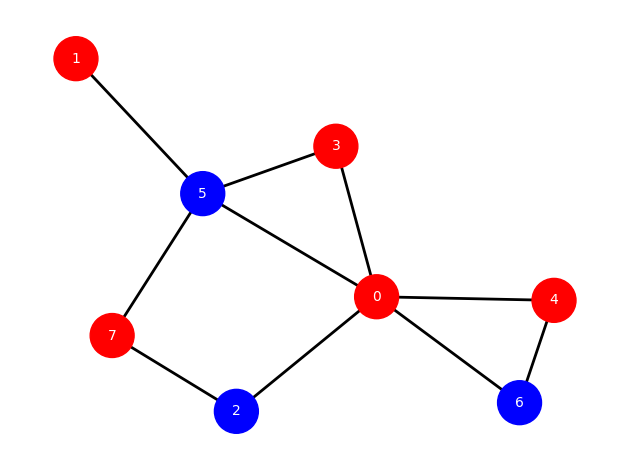

In [71]:
# Plot the best found assignment (if several only plot the first one)
assignment = int_to_bitstring(rank_dict[np.argmax(prob_per_rank_final)][0], n)
node_colors = ['blue' if assignment[i] else 'red' for i in range(n)]

pos = nx.spring_layout(g, seed=42)
nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=node_size)
nx.draw_networkx_edges(g, pos, width=2, alpha=1, edge_color="black", style="solid")

# Display node labels (indices)
nx.draw_networkx_labels(g, pos, font_size=10, font_color="white")

# Edge labels if weighted
if weighted:
    edge_labels = nx.get_edge_attributes(g, 'weight')
    # Round to 2 decimals for display purposes
    edge_labels = {e: f"{w:.2f}" for e, w in edge_labels.items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='magenta')

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
print(f"Best solutions are of ranking r={np.argmax(prob_per_rank_final)} among {len(rank_dict)} rankings")
print(f"Integer representation: {rank_dict[np.argmax(prob_per_rank_final)]}")
print(f"Binary representation: {[format(i, f'0{n}b') for i in rank_dict[np.argmax(prob_per_rank_final)]]}")
print(f"Displayed assignment: x={bitstring_to_int(assignment)} ({format(bitstring_to_int(assignment), f'0{n}b')})")
plt.show()

### 2- Quantum circuit

In [72]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer.primitives import SamplerV2
from qiskit.quantum_info import Statevector

We define the cost and mixer Hamiltonians and the circuit implementing SamBa-GQW in Qiskit. The MaxCut cost function is:
$$C(x)=-\sum_{i<j}w_{ij}(x_i+x_j-2x_ix_j).$$
Using the relation $x_i=(1-s_i)/2$ with $s_i\in\{-1,1\}$, we rewrite the cost function with Ising variables:
$$C(s)=-\frac{1}{2}\sum_{i<j}w_{ij}(1-s_is_j).$$
The related cost Hamiltonian is:
$$H_C=-\frac{1}{2}\sum_{i<j}w_{ij}(\mathbb{I}-\sigma^Z_i\sigma^Z_j),$$
where $\sigma^Z_i$ is the Pauli-$Z$ matrix applied on qubit $i$.

In [73]:
# MaxCut cost Hamiltonian
def cost_hamiltonian(n, g, dt):
    qc = QuantumCircuit(n)
    q = qc.qubits
    for (j, k) in g.edges():
        weight = g[j][k].get('weight', 1)  # default to 1 if unweighted graph
        qc.cx(q[j], q[k])
        qc.rz(float(dt * weight), q[k])
        qc.cx(q[j], q[k])
    return qc.to_gate(label='$H_C$')

# X-mixer Hamiltonian
def mixer_hamiltonian(n,gamma,dt):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.rx(float(-2*gamma*dt), q[i])
    return qc.to_gate(label='$\Gamma (t)H_M$')

# SamBa-GQW circuit
def sambaGQW_circuit(qc,samba_gqw,p,cost_hamiltonian,mixer_hamiltonian,store_probabilities=False):
    n = samba_gqw.n_qubit
    
    # To store the probability vector after each layer of cost/mixer Hamiltonians for analysis purpose if store_probabilities=True
    probability_vector_list = []

    # Cost and mixer Hamiltonians
    for l in range(len(samba_gqw.mean_gaps)-1):
        for r in range(1,p[l]+1):
            tau_l = np.pi/(2*np.sqrt(2)*samba_gqw.mean_gaps[l])
            gamma_l_r = samba_gqw.mean_gaps[l] - (r+1/2)*((samba_gqw.mean_gaps[l]-samba_gqw.mean_gaps[l+1])/p[l])
            cost_hamiltonian_gate = cost_hamiltonian(n,g,tau_l/p[l])
            mixer_hamiltonian_gate = mixer_hamiltonian(n,gamma_l_r,tau_l/p[l])

            qc.append(cost_hamiltonian_gate,qc.qubits)
            qc.append(mixer_hamiltonian_gate,qc.qubits)
            
            # Get the current probability vector after this step, we need to swap the qubits because of Qiskit ordering
            if store_probabilities:
                # Get the statevector probabilities
                prob = Statevector.from_instruction(qc).probabilities()
                # Reshape into n-dimensional tensor
                tensor = prob.reshape([2]*n)
                # Reverse qubit order
                tensor_reordered = tensor.transpose(list(reversed(range(n))))
                # Flatten back to vector
                prob_reordered = tensor_reordered.flatten()
                # Add it to the list
                probability_vector_list.append(prob_reordered)

    return qc, probability_vector_list

We construct the full quantum circuit that implements SamBa-GQW.

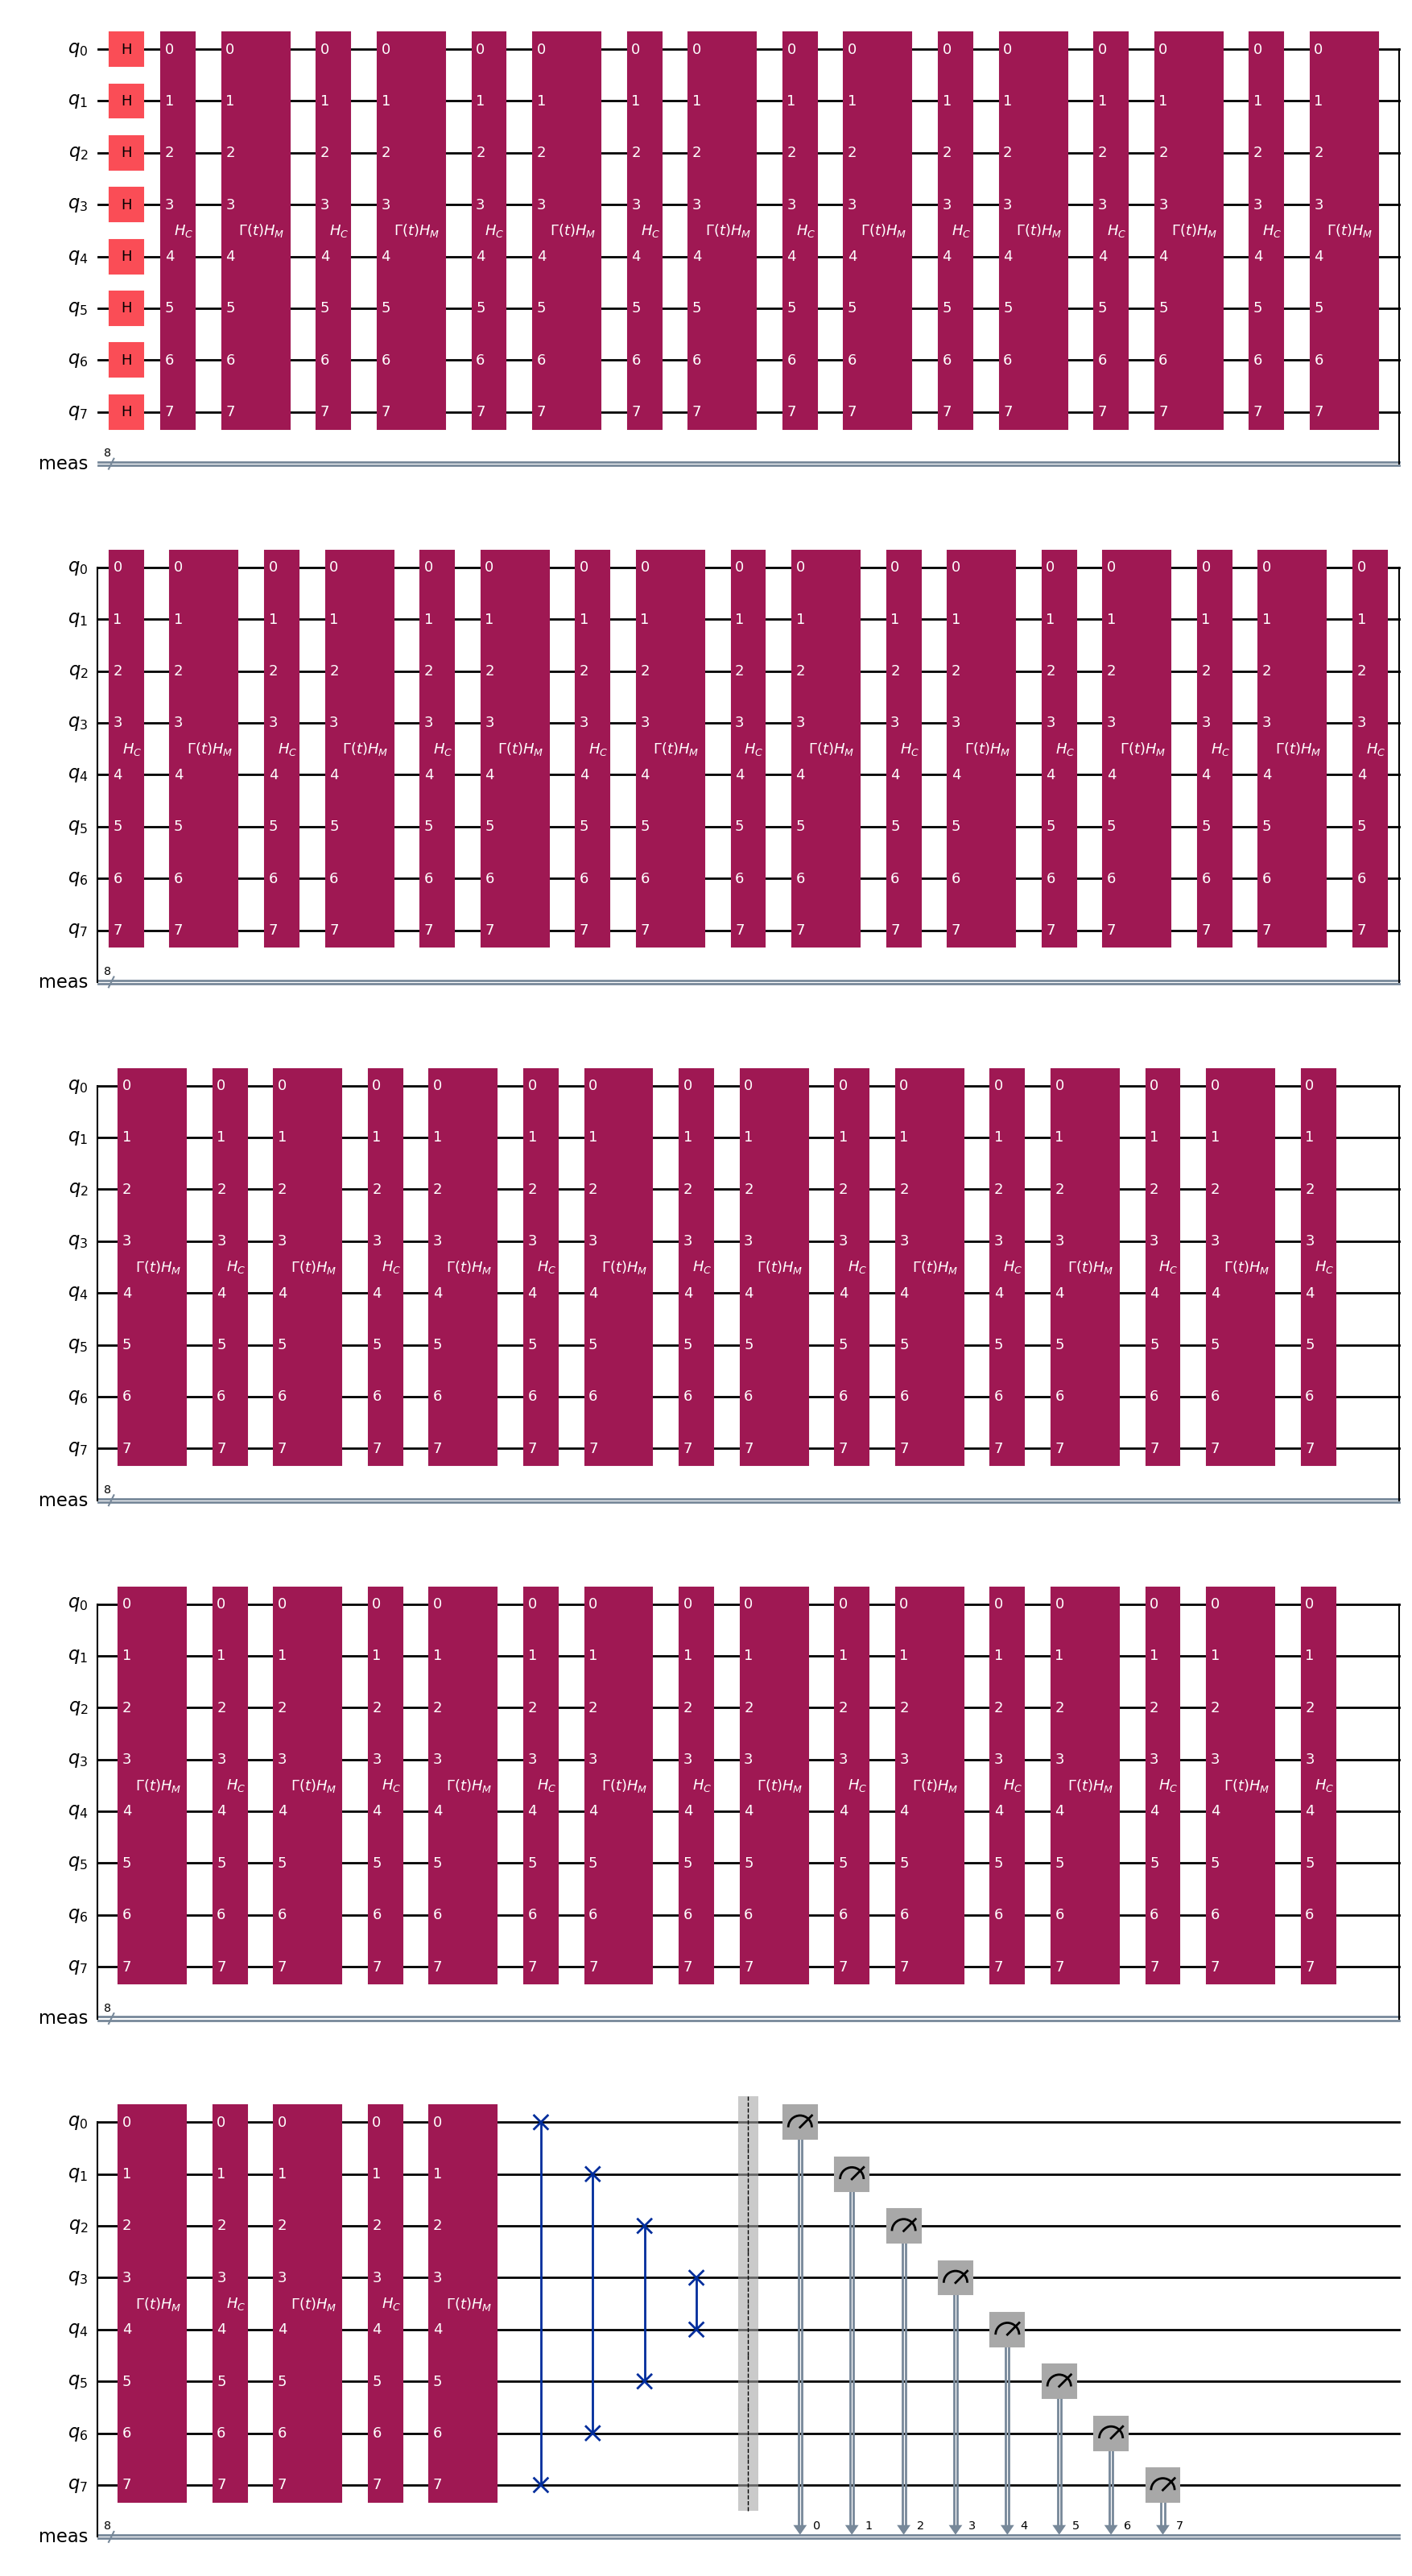

In [74]:
# List containing the number of subinterval per interval for hopping rate discretization (see Fig. 2 of the paper)
p = [5 for _ in range(len(samba_gqw.mean_gaps))] # here each interval is splitted into 5 subintervals

# We create our quantum circuit
q = QuantumRegister(n,name='q')
qc = QuantumCircuit(q)

# State preparation (uniform superposition for X-mixer)
qc.h(q)

# We create the circuit of SamBa-GQW (we can store probability vector at each layer, i.e. 1 unit of depth, for analysis purpose)
store_probabilities = True
qc, probability_vector_list = sambaGQW_circuit(qc,samba_gqw,p,cost_hamiltonian,mixer_hamiltonian,store_probabilities=store_probabilities)

# Swaps for correct ordering (because of Qiskit ordering)
for i in range(n//2):
    qc.swap(q[i],q[n-i-1])

# Measurements in the computational basis
qc.measure_all()

# Draw the circuit
qc.decompose(reps=0).draw('mpl')

In [75]:
# We execute the circuit (results from the measurements)
sampler = SamplerV2()
job = sampler.run([qc.decompose(reps=1)], shots=1000)
job_result = job.result()
res = job_result[0].data.meas.get_counts()

# Map the values of res to probabilities
norm = np.sum(list(res.values()))
for i in res.keys():
    res[i] = res[i]/norm

# Get the correct probability vector (index i contains probability of measuring computational basis i)
prob_vector = np.zeros(2**n)

for bitstring, prob in res.items():
    idx = int(bitstring, 2)
    prob_vector[idx] = prob

We compute again several metrics over time for analysis purposes and plot them (only if we store probabilities during the circuit).

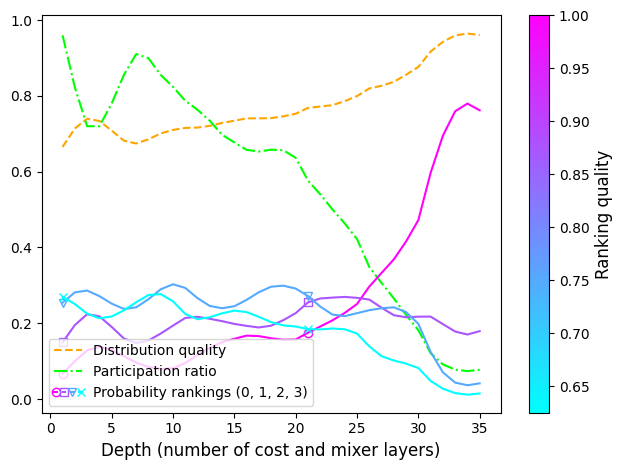

In [76]:
if store_probabilities:
    # Metrics
    prob_over_time_circuit = probability_vector_list
    distribution_quality_over_time_circuit = [distribution_quality(pr,list(cost_quality_dict.values())) for pr in prob_over_time_circuit]
    probabilities_per_rank_over_time_circuit = [[np.sum(pr[rank_dict[r]]) for pr in prob_over_time_circuit] for r in list(rank_dict.keys())]
    patricipation_ratio_over_time_circuit = 1 / (2**n * np.sum(np.vstack(prob_over_time_circuit)**2, axis=1))

    # We select the rankings for which we want to display the measurement probabilities over time
    rank_to_display = [0,1,2,3]

    # We plot several metrics over time
    plot_performance(
        distribution_quality_over_time_circuit,
        patricipation_ratio_over_time_circuit,
        probabilities_per_rank_over_time_circuit,
        np.arange(1,len(prob_over_time_circuit)+1),
        [cost_quality_dict[rank_dict[i][0]] for i in list(rank_dict.keys())],
        rank_list=rank_to_display,
        rank_dict=rank_dict,
        pourcentage=0,
        save=False,
        figname='maxcut.png',
        marker_list=None,
        markevery=20,
        markersize=6,
        show_colorbar=True,
        show_legend=True,
        xlabel='Depth (number of cost and mixer layers)'
    )

We display the initial and final ranking distributions.

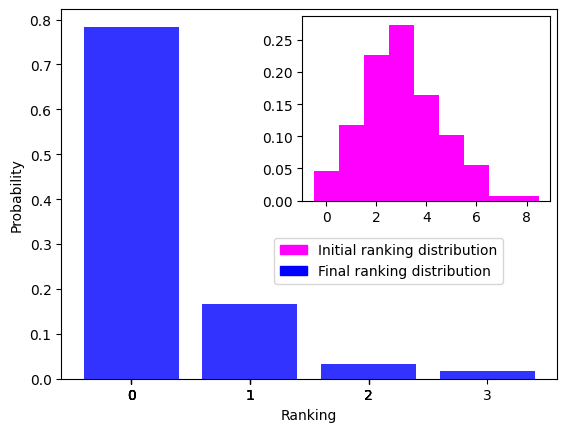

In [77]:
probabilities_per_rank_measurements = [np.sum(prob_vector[rank_dict[r]]) for r in list(rank_dict.keys())]
prob_per_rank_final_circuit = np.array([probabilities_per_rank_measurements[r] for r in list(rank_dict.keys())])

plot_ranking_distribution(prob_per_rank_final=prob_per_rank_final_circuit,
                        prob_per_rank_init=prob_per_rank_init, # computed in the Hamiltonian evolution part
                        threshold=1e-3,
                        num_ticks=15,
                        inset_plot_size=50,
                        inset_plot_label='Initial ranking distribution',
                        main_plot_label='Final ranking distribution',
                        save=False,
                        figname='ranking_distribution.png')

We select the **measured** computational state with the **lowest cost** to be our best approximation.

In [78]:
best_found_assigment = min(res.keys(), key=lambda b: maxcut_cost(int_to_bitstring(int(b,2),n),adj_matrix))
print(f'The best found assignment by SamBa-GQW is x={int(best_found_assigment,2)} ({best_found_assigment}) of ranking r={next((key for key, values in rank_dict.items() if int(best_found_assigment,2) in values))}')

The best found assignment by SamBa-GQW is x=44 (00101100) of ranking r=0


We now display the original graph with the best assignment provided by SamBa-GQW (with quantum circuit).

Displayed assignment: x=44 (00101100)


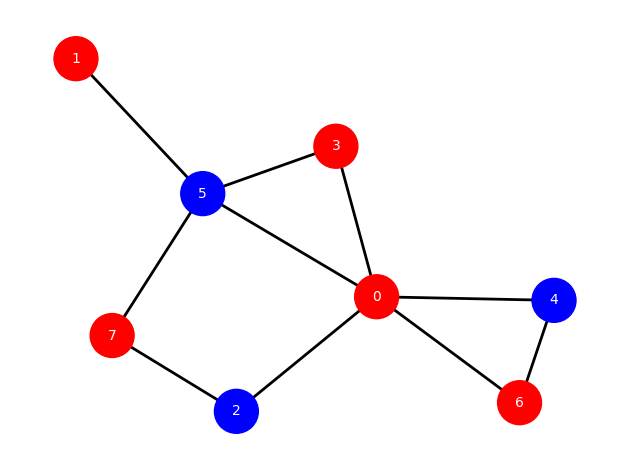

In [79]:
# Plot the best found assignment
node_colors = ['blue' if best_found_assigment[i] == '1' else 'red' for i in range(n)]

pos = nx.spring_layout(g, seed=42)
nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=node_size)
nx.draw_networkx_edges(g, pos, width=2, alpha=1, edge_color="black", style="solid")

# Display node labels (indices)
nx.draw_networkx_labels(g, pos, font_size=10, font_color="white")

# Edge labels if weighted
if weighted:
    edge_labels = nx.get_edge_attributes(g, 'weight')
    # Round to 2 decimals for display purposes
    edge_labels = {e: f"{w:.2f}" for e, w in edge_labels.items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='magenta')

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
print(f"Displayed assignment: x={int(best_found_assigment,2)} ({format(int(best_found_assigment,2), f'0{n}b')})")
plt.show()